# Notebook Overview
The objective of this notebook is to clean and explore historical forecasted avalanche conditions for the Sea to Sky region as reported by Avalanche Canada (https://www.avalanche.ca/). Specifically, this notebook creates a final cleaned dataset and attempts to assess forecast anamolies between day of and one and two day out forecasted conditions. 

#### The Data
The dataset covers the period 2011-11-02 through 2020-04-15 and includes day of forecasted conditions and one and two day out forecasted conditions. Additionally, any forecast problems, as written by the forecaster, are included for day of forecasted conditions. The dataset was scraped from the Avalanche Canada forecast archives (https://www.avalanche.ca/forecasts/archives) using Selenium and Python. 

#### Key Terms
A few key terms that are important to understand in this analysis:
* Day of Conditions - The current days forecasted avalanche conditions. This is the most up to date forecast.
* Day of Conditions Plus 1/2 - Tomorrow and the day after tomorrows forecasted avalanche conditions. These are always superceded by the Day of Conditions
* Avalanche Status Code - Risk of avalanches on a scale of 1-5 with 5 being Extreme and 1 being Low
* Alpine - Elevations above treeline
* Treeline - Elevations at or near treeline
* Below Treeline - Elevations clearly in the forest

#### Notebook Outline
A basic outline for the notebook is as follows:
1. Load data
2. Clean data
3. Visualize data

## Library Imports

In [12]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

## Helper Functions

In [13]:
# helper functions
def percent_missing(df, name):
    '''function to compute the percent NaN data in each column of a dataframe'''
    
    perc_missing = df.isna().sum() / len(df) * 100
    
    return print('Percent Missing in Each Column Before Filtering:', name, '\n \n', perc_missing, '\n')

## Load Dataset

In [14]:
# define absolute path to raw data folder
raw_data_root_path = os.path.abspath('../data/raw')

# raw data filenames
current_conditions_file = 'current_avalanche_conditions_sea_to_sky.csv'  # day of forecast
current_plus1_conditions_file = 'current_plus1_avalanche_conditions_sea_to_sky.csv'  # tomorrow forecast
current_plus2_conditions_file = 'current_plus2_avalanche_conditions_sea_to_sky.csv'  # day after tomorrow forecast
  
# define absolute path to raw data files
current_conditions_path = os.path.join(raw_data_root_path, current_conditions_file)
current_plus1_conditions_path = os.path.join(raw_data_root_path, current_plus1_conditions_file)
current_plus2_conditions_path = os.path.join(raw_data_root_path, current_plus2_conditions_file) 

# load raw data to dataframe, parse dates as datetime index
df_raw_current = pd.read_csv(current_conditions_path, parse_dates=['date_valid'])
df_raw_current_plus1 = pd.read_csv(current_plus1_conditions_path, parse_dates=['date_valid'])
df_raw_current_plus2 = pd.read_csv(current_plus2_conditions_path, parse_dates=['date_valid'])

## Clean Dataset

In [16]:
# list of dataframes to clean
dataframes = [df_raw_current, df_raw_current_plus1, df_raw_current_plus2]

# check for percent missing values for each dataframe
for df, name in zip(dataframes, ['current', 'current+1', 'current+2']):
    percent_missing(df, name)
    
# # replace zero values with NaN and remove any row that has NaN value for avalanche status
for df in dataframes:
    df.replace(0.0, np.nan, inplace=True)
    df.dropna(subset=['alpine_status_code', 'treeline_status_code', 'belowtree_status_code'], inplace=True)
    
# remove extra row in current day forecast
df_raw_current.drop(columns=['Unnamed: 8'], inplace=True)

# replace missing problem text with No Text statement
df_raw_current['problems'].replace(np.nan, 'No Text', inplace=True)

# assign dataframes to new processed dataframe
df_cleaned_current = df_raw_current
df_cleaned_current_plus1 = df_raw_current_plus1
df_cleaned_current_plus2 = df_raw_current_plus2

Percent Missing in Each Column Before Filtering: current 
 
 date_valid                0.000000
alpine_status             7.440101
alpine_status_code        7.440101
treeline_status           7.440101
treeline_status_code      7.440101
belowtree_status          7.440101
belowtree_status_code     7.440101
problems                 26.607818
Unnamed: 8               99.810845
dtype: float64 

Percent Missing in Each Column Before Filtering: current+1 
 
 date_valid               0.000000
alpine_status            7.440101
alpine_status_code       7.440101
treeline_status          7.440101
treeline_status_code     7.440101
belowtree_status         7.440101
belowtree_status_code    7.440101
dtype: float64 

Percent Missing in Each Column Before Filtering: current+2 
 
 date_valid               0.000000
alpine_status            7.440101
alpine_status_code       7.440101
treeline_status          7.440101
treeline_status_code     7.440101
belowtree_status         7.440101
belowtree_status_code 

## Explore Data

Show the following:

1. pie chart for each forecast period and each elevation
2. distribution by month
3. distribution by year
4. look at other la nina years
5. anamoly between forecasts

#### Visualization of Day Of avalanche conditions in Sea to Sky Region 2011-2020

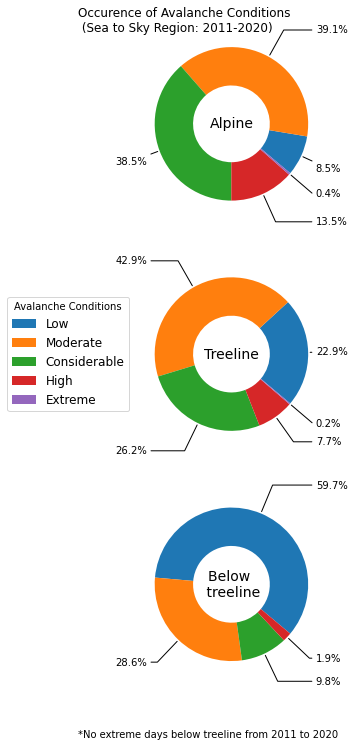

In [17]:
# percent occurence of each avalanche condition for each elevation
avy_perc_occur_alpine = df_cleaned_current['alpine_status_code'].value_counts(normalize=True) * 100
avy_perc_occur_treeline = df_cleaned_current['treeline_status_code'].value_counts(normalize=True) * 100
avy_perc_occur_belowtree = df_cleaned_current['belowtree_status_code'].value_counts(normalize=True) * 100

# combine into one dataframe for plotting ease
avy_perc_occur_all_elev = pd.concat([avy_perc_occur_alpine, avy_perc_occur_treeline, avy_perc_occur_belowtree], axis=1)

# properties for donut charts
status_labels = ['Low', 'Moderate', 'Considerable', 'High', 'Extreme']
title_labels = ['Alpine', 'Treeline', 'Below \n treeline']

# create donut chart for each elevation
fig, ax = plt.subplots(3,1,figsize=(7,12), subplot_kw=dict(aspect="equal"), facecolor='white')

for i, col in enumerate(avy_perc_occur_all_elev):
    
    data = avy_perc_occur_all_elev[col]  # column of dataframe to render
    data.dropna(inplace=True)  # remove any NaN rows
        
    donut_labels = [str(round(y,1)) + '%' for y in list(data)]
            
    wedges, texts = ax[i].pie(data, wedgeprops=dict(width=0.5), startangle=-40)  # create donut chart
        
    #  create lines and labels
    kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
    
    for j, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1  # a bit of 9th grade geometry
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax[i].annotate(donut_labels[j], xy=(x, y), xytext=(1.1*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
        
    ax[i].text(0,0,title_labels[i], fontsize='14', ha='center', va='center')  # add title to donut center
    
    if i == 0:
        ax[i].text(-2,1.2,'Occurence of Avalanche Conditions \n (Sea to Sky Region: 2011-2020)', fontsize='12')
    
    if i == 1:
        ax[i].legend(wedges, status_labels, title="Avalanche Conditions", loc='center left', 
                     bbox_to_anchor=(-0.7, 0.25, 0.5, 0.5), prop=dict(size=12))
        
ax[2].text(-2, -2, '*No extreme days below treeline from 2011 to 2020')

plt.savefig('../figures/percent-occurence-avy-conditions-sea-to-sky-2011-2020.png')

#### Visualization of Day Of avalanche conditions by year

In [140]:
years = df_cleaned_current.date_valid.dt.year.unique()

alpine_conditions = []
treeline_conditions = []
belowtree_conditions = []
year_labels = []

for i, year in enumerate(years[:-1]):
    
    start = '{}-11-01'.format(year)
    end = '{}-05-01'.format(year+1)
        
    label = '{} - {}'.format(year, year+1)
    year_labels.append(label)
        
    alpine_conditions.append(df_cleaned_current[(df_cleaned_current.date_valid > start) & 
                                                (df_cleaned_current.date_valid < end)]['alpine_status_code'].value_counts())
   
    treeline_conditions.append(df_cleaned_current[(df_cleaned_current.date_valid > start) & 
                                                (df_cleaned_current.date_valid < end)]['treeline_status_code'].value_counts())
    
    belowtree_conditions.append(df_cleaned_current[(df_cleaned_current.date_valid > start) & 
                                                (df_cleaned_current.date_valid < end)]['belowtree_status_code'].value_counts())

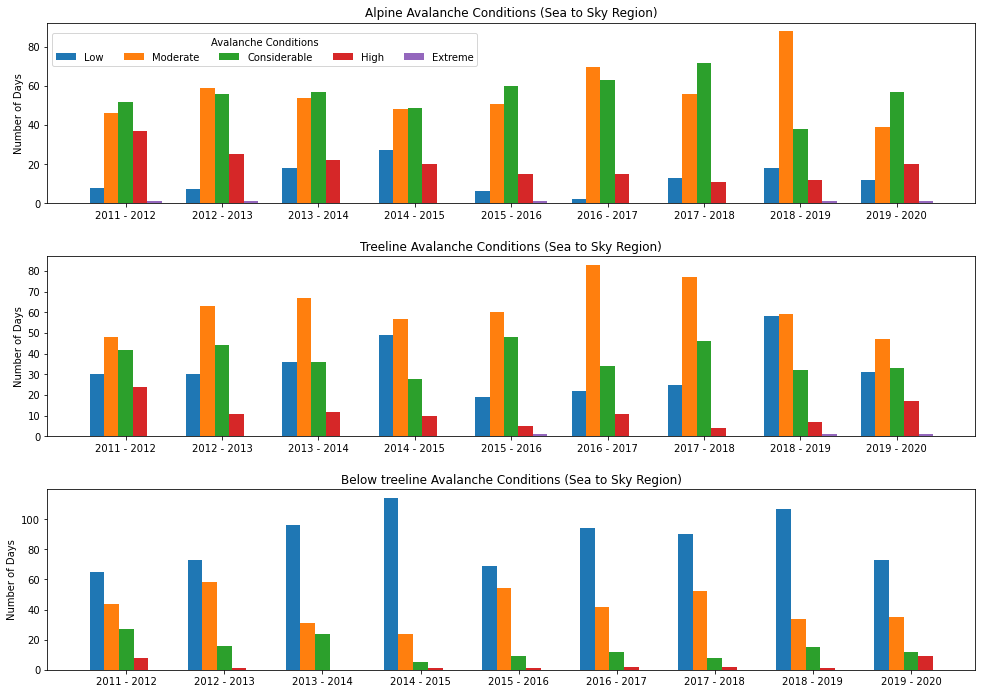

In [184]:
df_alpine = pd.DataFrame(alpine_conditions)
df_treeline = pd.DataFrame(treeline_conditions)
df_belowtree = pd.DataFrame(belowtree_conditions)

title_label = ['Alpine', 'Treeline', 'Below treeline']
x = np.arange(len(alpine_conditions))
width = 0.15

fig, ax = plt.subplots(3,1,figsize=(14,10), facecolor="white")

for i, df in enumerate([df_alpine, df_treeline, df_belowtree]):
    
    rects1 = ax[i].bar(x - width*2, df[1], width, label='Low')
    rects2 = ax[i].bar(x - width, df[2], width, label='Moderate')
    rects3 = ax[i].bar(x, df[3], width, label='Considerable')
    rects4 = ax[i].bar(x + width, df[4], width, label='High')
    
    if 5 in df.columns:
        rects5 = ax[i].bar(x + width*2, df[5], width, label='Extreme')
        
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(year_labels)
    ax[i].set_title('{} Avalanche Conditions (Sea to Sky Region)'.format(title_label[i]))
    ax[i].set_ylabel('Number of Days')
    
ax[0].legend(title="Avalanche Conditions", loc='center left', bbox_to_anchor=(0, 0.6, 0.5, 0.5), ncol=5)

fig.tight_layout(pad=2)

plt.savefig('../figures/yearly-distribution-avy-conditions-sea-to-sky-2011-2020.png')


#### Visualization of Day Of avalanche conditions by month

In [ ]:
avy_likelihood_alpine = df_cleaned_current['alpine_status_code'].value_counts(normalize=True) * 100
avy_likelihood_treeline = df_cleaned_current['treeline_status_code'].value_counts(normalize=True) * 100
avy_likelihood_belowtree = df_cleaned_current['belowtree_status_code'].value_counts(normalize=True) * 100

In [ ]:
for axes in ax.reshape(-1):
    print(axes)

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(14,14), subplot_kw=dict(aspect="equal"))

len(ax)